# Маркетинговое исследование развлекательного приложения

Развлекательное приложение Procrastinate Pro+, несмотря на огромные вложения в рекламу, последние несколько месяцев терпит убытки. 

Цель исследования: установить причины убытков компании путем исследования рекламных кампаний и профилей пользователей.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Ход исследования:
- получить данные от компании, выполнить предобработку, обработать пропуски, дубликаты, аномальные значения
- выполнить дополнительные необходимые расчеты
- изучить, откуда приходят пользователи и какими устройствами они пользуются,
- посчитать, сколько стоит привлечение пользователей из различных рекламных каналов;
- рассчитать, сколько денег приносит каждый клиент,
- выяснить, когда расходы на привлечение клиента окупаются,
- проанализировать, какие факторы мешают привлечению клиентов.

## Шаг 1. Загрузка данных и подготовка к анализу

Загрузим данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

Изучим данные и выполним предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

**Описание данных**

В нашем распоряжении три датасета. Файл `visits_info_short.csv` хранит лог сервера с информацией о посещениях сайта, `orders_info_short.csv` — информацию о заказах, а `costs_info_short.csv` — информацию о расходах на рекламу.

Структура `visits_info_short.csv`:<br>
`User Id` — уникальный идентификатор пользователя,<br>
`Region` — страна пользователя,<br>
`Device` — тип устройства пользователя,<br>
`Channel` — идентификатор источника перехода,<br>
`Session Start` — дата и время начала сессии,<br>
`Session End` — дата и время окончания сессии.

Структура `orders_info_short.csv`:<br>
`User Id` — уникальный идентификатор пользователя,<br>
`Event Dt` — дата и время покупки,<br>
`Revenue` — сумма заказа.

Структура `costs_info_short.csv`:<br>
`dt` — дата проведения рекламной кампании,<br>
`Channel` — идентификатор рекламного источника,<br>
`costs` — расходы на эту кампанию.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime, timedelta
#импортируем необходимые библиотеки

try: #используем try except для предупреждения ошибки
    visits = pd.read_csv('visits_info_short.csv')
    orders = pd.read_csv('orders_info_short.csv')
    costs = pd.read_csv('costs_info_short.csv')  #загружаем датасеты в переменные
except:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')

Рассмотрим общую информацию о датасетах и количестве пропусков

In [2]:
visits.head() #посмотрим первые 5 строк

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [3]:
print(visits.info()) #посмотрим общую информацию

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None


В датасете `visits` все значения в столбцах заполнены - пропусков нет. Всего 309901 запись, столбцы `Session Start` и `Session End` хранят в себе дату - поэтому нужно будет поменять тип данных в этих столбцах.<br>
Также перед предобработкой данных выполним переименование столбцов в змеиный регистр.

In [4]:
visits=visits.rename(columns={'User Id': 'user_id', 'Region': 'region', 
                              'Device': 'device', 'Channel': 'channel', 'Session Start': 'sess_start', 
                              'Session End': 'sess_end' }) #переименовывание столбцов

In [5]:
visits['sess_start'] = pd.to_datetime(visits['sess_start'])
visits['sess_end'] = pd.to_datetime(visits['sess_end'])  #приводим к типу дата

Проверим, что тип поменялся, а также проверим `visits` на дубликаты.

In [6]:
print(visits.info()) #смотрим общуюи информацию
print()
print('Дубликатов', visits.duplicated().sum()) #считаем дубликаты

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     309901 non-null  int64         
 1   region      309901 non-null  object        
 2   device      309901 non-null  object        
 3   channel     309901 non-null  object        
 4   sess_start  309901 non-null  datetime64[ns]
 5   sess_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
None

Дубликатов 0


Пропусков и дубликатов в `visits` не обнаружилось. Проверим две другие таблицы аналогичными методам.

In [7]:
orders.info() #смотрим общую инфу

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [8]:
orders.head() #первые 5 строк

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [9]:
orders=orders.rename(columns={'User Id': 'user_id', 'Event Dt': 'event_dt', 'Revenue': 'revenue'}) #переименовывание столбцов

In [10]:
orders['event_dt'] = pd.to_datetime(orders['event_dt']) #приводим к типу дата

In [11]:
print(orders.info()) #общая информация
print()
print('Дубликатов', orders.duplicated().sum()) #считаем дубликаты

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB
None

Дубликатов 0


Таблица `orders` содержит 40212 записей, дубликатов и пропусков нет. Как и в случае с первой таблицей, были переименованы столбцы в змеиный регистр, а также столбец `event_dt` приведен к типу данных "date". 

Посмотрим на столбцей с суммой заказа `revenue`, чтобы узнать о нем побольше.

In [12]:
orders['revenue'].describe() #смотрим среднее, медиану и максимальное

count    40212.000000
mean         5.370608
std          3.454208
min          4.990000
25%          4.990000
50%          4.990000
75%          4.990000
max         49.990000
Name: revenue, dtype: float64

В среднем клиенты компании делают покупки на 5,37 у.е., медиана = 4,99. Можно сделать вывод, что клиенты покупают покупают по 1 продукту - похоже на ежемесячную подписку на приложение. Редкие клиенты покупают сразу несколько месяцев. Возможно, точка роста компании - чтобы клиенты покупали не 1 месяц, а сразу несколько.

Проведем аналогичные вычисления для `costs`.

In [13]:
print(costs.head()) #первые 5 строк
print()
print(costs.info()) #общая информация

           dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None


In [14]:
costs=costs.rename(columns={'Channel': 'channel'}) #переименовывание столбцов

In [15]:
costs['dt'] = pd.to_datetime(costs['dt']) #приводим к типу дата

In [16]:
print(costs.info()) #общая информация
print()
print('Дубликатов', costs.duplicated().sum()) #считаем дубликаты

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB
None

Дубликатов 0


В таблице `costs` 1800 записей, дубликатов и пропусков нет. Переименован столбец с датой рекламной кампании, а также изменен тип данных на `date`.

Выделим в двух таблицах год, месяц, неделю и день и добавим новые столбцы.

In [17]:
visits['session_year'] = visits['sess_start'].dt.year #выделяем год
visits['session_month'] = visits['sess_start'].dt.month #выделяем месяц
visits['session_week'] = visits['sess_start'].dt.isocalendar().week #выделяем неделю
visits['session_date'] = visits['sess_start'].dt.date #выделяем дату

In [18]:
orders['year'] = orders['event_dt'].dt.year #выделяем год
orders['month'] = orders['event_dt'].dt.month #выделяем месяц
orders['week'] = orders['event_dt'].dt.isocalendar().week #выделяем неделю
orders['date'] = orders['event_dt'].dt.date #выделяем дату

In [19]:
costs['year'] = costs['dt'].dt.year #выделяем год
costs['month'] = costs['dt'].dt.month #выделяем мсяц
costs['week'] = costs['dt'].dt.isocalendar().week #выделяем неделю
costs['dt'] = costs['dt'].dt.date

Данные готовы к анализу.

## Шаг 2. Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

### Функция для создания профилей пользователей:

In [20]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'sess_start'])
        .groupby('user_id')
        .agg(
            {
                'sess_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'sess_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### Функция для подсчета Retention Rate

In [21]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'sess_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['sess_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Функция для подсчета конверсии

In [22]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Функция для подсчета LTV

In [23]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### Функция для сглаживания данных на графике

In [24]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

### Функция для построения графика Retention Rate

In [25]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

### Функция для построения графика конверсии

In [26]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))
    plt.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show() 

### Функция для построения графиков LTV, ROI

In [27]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Шаг 3. Исследовательский анализ данных

В ходе исследовательского анализа данных будут:
- составлены профили пользователей. Определены минимальная и максимальная дата привлечения пользователей.
- определены страны, из которых приходят пользователи в приложении, и страна, где больше всего платящих пользователей.
- определены устройства, которыми пользуются клиенты, и устройства, клиенты которых чаще платят. Будет создана таблица, отражающая количество пользователей и доля платящих для каждого устройства.
- изучены рекламные источники привлечения и определены каналы, из которых пришло больше всего платящих пользователей. А также таблица, отражающая количество пользователей и доля платящих для каждого канала привлечения.

### Профили пользователей

Для составления профилей пользователей воспользуемся готовой функцией `get_profiles`.

In [28]:
profiles = get_profiles(visits, orders, costs) #создаем профили
profiles.head() #первые 5 строк

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Минимальная и максимальная дата привлечения пользователей: **01.05.2019** и **27.10.2019**.

In [29]:
min_analysis_date = profiles['dt'].min() #минимальная дата привлечения
max_analysis_date = profiles['dt'].max() #максимальная дата привлечения

display(min_analysis_date) #выводим
display(max_analysis_date)

datetime.date(2019, 5, 1)

datetime.date(2019, 10, 27)

Момент анализа по заданию **01.11.2019**, горизонт анализа = **14** дней.

In [30]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа 1 ноября 2019 года
horizon_days = 14  # горизонт анализа 14 дней

Данные в предоставленных датафреймах от 01.05.2019 до 27.10.2019, что соответствует заданию и не требует дополнительного выделения данных из датафреймов.

### Страны, из которых приходят пользователи в приложении, и страна, где больше всего платящих пользователей.

Для выяснения стран построим две сводные таблицы:
1. Количество уникальных пользователей в каждой стране
2. Количество уникальных платящих пользователей в каждой стране

В обоих случаях `United States` сильно вырывается вперед: уникальных пользователей 100 002, платящих 6902.


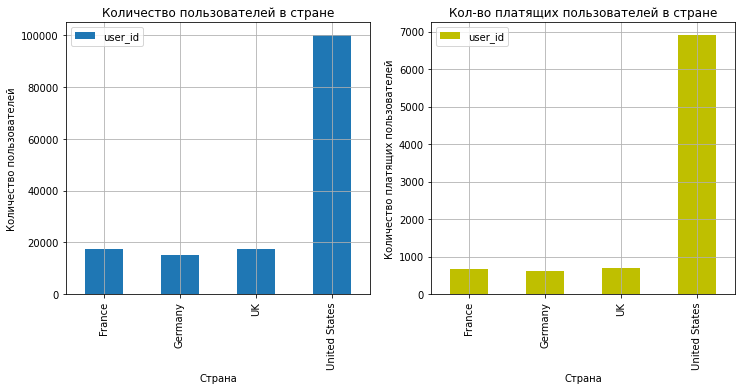

In [31]:
ax1 = plt.subplot(1, 2, 1) #создаем решетку для совместного отображения графиков
user_per_region = profiles.pivot_table(index='region', values='user_id', aggfunc='nunique') #сводная таблица по регионам и количеству уникальных пользователей
#график
user_per_region.plot(kind='bar', grid=True, ax=ax1, figsize=(12, 5), xlabel='Страна', ylabel='Количество пользователей', title='Количество пользователей в стране')

ax2 = plt.subplot(1, 2, 2) 
#сводная таблица по регионам и платящим пользователям
payusers_per_region = profiles.query('payer==True').pivot_table(index='region', values='user_id', aggfunc='nunique')
#график
payusers_per_region.plot(grid=True, figsize=(12, 5), ax=ax2, kind='bar', color='y', xlabel='Страна', ylabel='Количество платящих пользователей', title='Кол-во платящих пользователей в стране')
#выводим графики
plt.show()

Также построим сводную таблицу, которая отразит долю платящих пользователей в стране.

,user_id_x,user_id_y,"proportion, %"
region,,,
France,17450,663,3.799427
Germany,14981,616,4.111875
UK,17575,700,3.982930
United States,100002,6902,6.901862


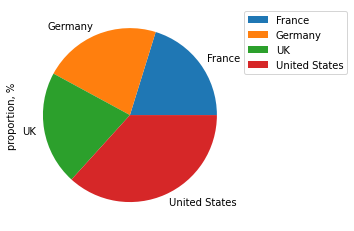

In [32]:
#соединяем таблицы с пользователями и платящими пользователями
proportion_region = user_per_region.merge(payusers_per_region, on='region')
#добавляем столбец с долей
proportion_region['proportion, %'] = proportion_region['user_id_y']/proportion_region['user_id_x']*100
#переименовываем столбцы
proportion_region.rename(columns={'user_id_x': 'All users', 'user_id_y': 'Pay users'})
display(proportion_region)
proportion_region.plot(kind='pie', x='region', y='proportion, %')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

И в этом случае явным лидером оказалась `United States`, доля платящих пользователей почти 7%.

### Устройства, которыми пользуются клиенты, и устройства, клиенты которых чаще платят

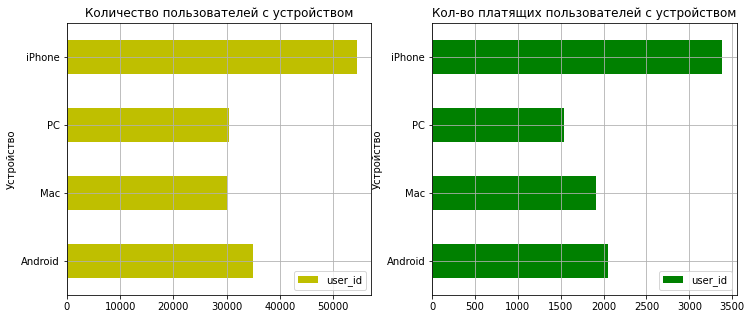

In [33]:
ax1 = plt.subplot(1, 2, 1)
device_per_region = profiles.pivot_table(index='device', values='user_id', aggfunc='nunique')
device_per_region.plot(kind='barh', grid=True, color='y', figsize=(12, 5), ax=ax1, xlabel='Устройство', ylabel='Количество пользователей', title='Количество пользователей c устройством')

ax2 = plt.subplot(1, 2, 2)
paydevice_per_region = profiles.query('payer==True').pivot_table(index='device', values='user_id', aggfunc='nunique')
paydevice_per_region.plot(grid=True, figsize=(12, 5), color='g', kind='barh', ax=ax2, xlabel='Устройство', ylabel='Количество платящих поьзователей', title='Кол-во платящих пользователей с устройством')
plt.show()

,All users,Pay users,"proportion, %"
device,,,
Android,35032,2050,5.851793
Mac,30042,1912,6.364423
PC,30455,1537,5.046790
iPhone,54479,3382,6.207897


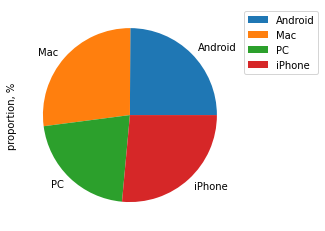

In [34]:
proportion_device = device_per_region.merge(paydevice_per_region, on='device')

proportion_device['proportion, %'] = proportion_device['user_id_y']/proportion_device['user_id_x']*100
proportion_device=proportion_device.rename(columns={'user_id_x': 'All users', 'user_id_y': 'Pay users'})
display(proportion_device)
proportion_device.plot(kind='pie', x='device', y='proportion, %')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Больше всего приложением пользуются владельцы `iPhone` (54 479 клиентов), на втором месте `Android` (35 032 клиента). 

Чаще всего платят пользователи `iPhone` (3 382 клиента) и `Android` (2 050 клиентов).

Доля платящих пользователей распределилась немного иначе: на первом месте владельцы `Mac` (6.36%), на втором `iPhone` (6.2%).

### Рекламные источники привлечения и каналы, из которых пришло больше всего платящих пользователей

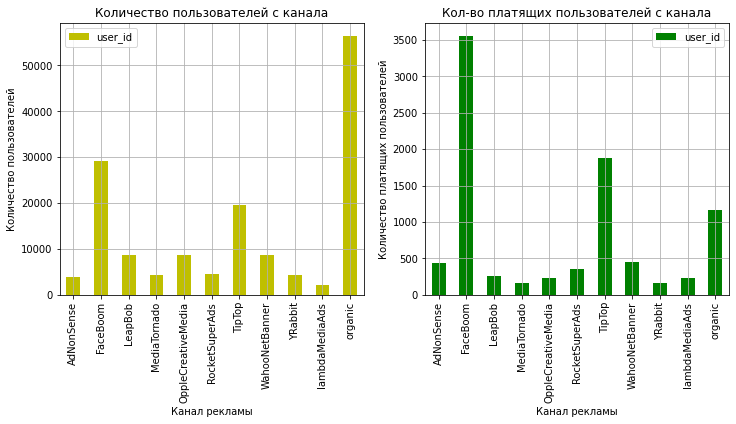

In [35]:
ax1 = plt.subplot(1, 2, 1)
channel_per_region = profiles.pivot_table(index='channel', values='user_id', aggfunc='nunique')
channel_per_region.plot(kind='bar', grid=True, color='y', figsize=(12, 5), ax=ax1, xlabel='Канал рекламы', ylabel='Количество пользователей', title='Количество пользователей с канала')

ax2 = plt.subplot(1, 2, 2)
paychannel_per_region = profiles.query('payer==True').pivot_table(index='channel', values='user_id', aggfunc='nunique')
paychannel_per_region.plot(grid=True, figsize=(12, 5), color='g', kind='bar', ax=ax2, xlabel='Канал рекламы', ylabel='Количество платящих пользователей', title='Кол-во платящих пользователей с канала')
plt.show()

In [36]:
proportion_channel = channel_per_region.merge(paychannel_per_region, on='channel')

proportion_channel['proportion, %'] = proportion_channel['user_id_y']/proportion_channel['user_id_x']*100
proportion_channel.rename(columns={'user_id_x': 'All users', 'user_id_y': 'Pay users'})

,All users,Pay users,"proportion, %"
channel,,,
AdNonSense,3880,440,11.340206
FaceBoom,29144,3557,12.204914
LeapBob,8553,262,3.063253
MediaTornado,4364,156,3.574702
OppleCreativeMedia,8605,233,2.707728
RocketSuperAds,4448,352,7.913669
TipTop,19561,1878,9.600736
WahooNetBanner,8553,453,5.296387
YRabbit,4312,165,3.826531


Больше всего пользователей пришли в приложение "органически" (56 439 клиентов) - то есть самостоятельно, через поисковик в браузере. На втором месте по привлечению находится `FaceBoom` (29 144 клиента), на третьем `TipTop` (19 561 клиент).

Больше всех платящих пользователей привлекли `FaceBoom` (3557 клиентов), `TipTop` (1878 клиентов).

Самую большую долю платящих пользователей привлекли `FaceBoom` (12.2%), `AdNonSense` (11.34%) и `lambdaMediaAds` (10.47%).

**Промежуточный вывод:**

Привлечение пользователей в компании осуществлялось с 01.05.2019 по 27.10.2019. Больше всего пользователей из United States (100 002 клиента), из них платящих 6 902 (6,9%).

Самым популярным устройством, с которого заходили в приложение, является iPhone - 54 479 клиентов, из них платящих 3 382 клиента (6,2%), на втором месте Android - 35 032 клиента, из них платящих 2 050 клиентов. Чаще всего покупают в приложении владельцы Mac, доля платящих пользователей = 6,36%.

Чаще в приложении приходят "органические" пользователи (56 439 клиентов), на втором месте рекламный источник "FaceBoom" - 29 144 клиента, из них платящих 3 557 клиентов (12,2%), на третьем месте TipTop - 1 878 клиентов (9,6%). Также высокая доля платящих пришла через каналы AdNonSense (11,34%) и lambdaMediaAds (10.47%).

## Шаг 4. Маркетинг

В ходе выполнения расчетов будут определены следующие пункты:
- Общая сумма расходов на маркетинг.
- Распределение трат по рекламным источниками
- Визуализация динамики изменения расходов во времени (неделя и месяц) по каждому источнику. 
- CAC. Средняя стоимость привлечения одного пользователя в разбивке по каналам.


### Общая сумма расходов на маркетинг

In [56]:
all_costs = costs['costs'].sum() #считаем общую сумму
print('Общая сумма расходов на маркетинг:', round(all_costs, 3)) #выводим

Общая сумма расходов на маркетинг: 105497.3


Посмотрим также на распределение трат по месяцам:

In [38]:
costs.groupby('month')['costs'].sum() #группируем по месяцам

month
5      9978.570
6     15090.045
7     16447.060
8     20657.870
9     22441.340
10    20882.415
Name: costs, dtype: float64

Всего на рекламу было потрачено 105 497,3 у.е. С течением времени с мая по сентябрь бюджет на рекламу увеличивался.

### Распределение трат по рекламным источниками

In [58]:
costs.groupby('channel')['costs'].sum().sort_values() #группируем по каналам

channel
YRabbit                 944.22
MediaTornado            954.48
lambdaMediaAds         1557.60
LeapBob                1797.60
RocketSuperAds         1833.00
OppleCreativeMedia     2151.25
AdNonSense             3911.25
WahooNetBanner         5151.00
FaceBoom              32445.60
TipTop                54751.30
Name: costs, dtype: float64

Больше всего было потрачено на `TipTop` (54 751), а также на `FaceBoom` (32 445).

### Визуализация динамики изменения расходов во времени (недели и месяцы) по каждому источнику.

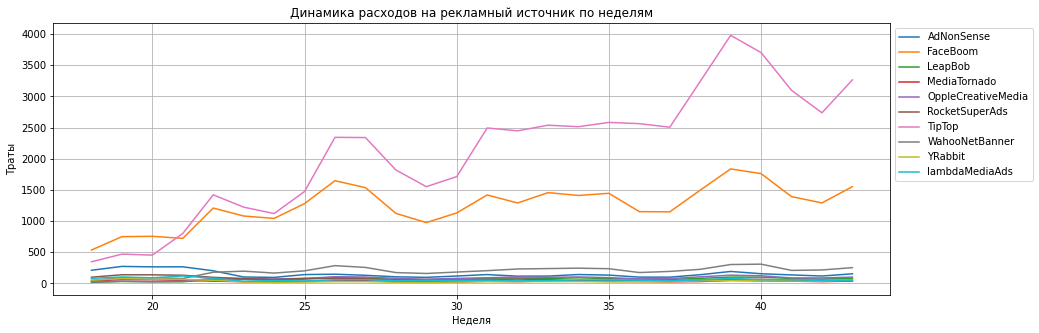

In [40]:
#сводная таблица по неделям и каналам
costs.pivot_table(index='week', columns ='channel', values ='costs', aggfunc='sum').plot(figsize=(15,5), grid=True)
#настраиваем график
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Неделя')
plt.ylabel('Траты')
plt.title('Динамика расходов на рекламный источник по неделям')
plt.show()

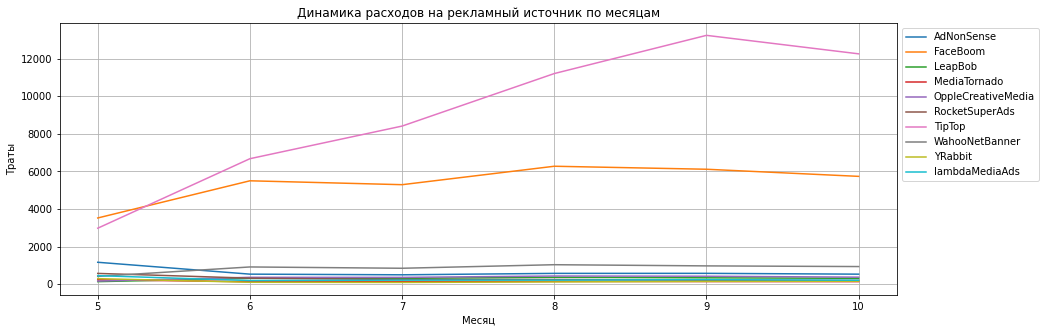

In [41]:
#сводная таблица по месяцам и каналам
costs.pivot_table(index='month', columns ='channel', values ='costs', aggfunc='sum').plot(figsize=(15,5), grid=True)
#настраиваем график
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Месяц')
plt.ylabel('Траты')
plt.title('Динамика расходов на рекламный источник по месяцам')
plt.show()

Больше всего компания тратила на TipTop и FaceBoom - их линии на графике растут со временем. На другие рекламные источники компания тратила намного меньше, возможно это является точкой роста - тратить на другие рекламные источники, в которых пользователи еще могут не знать о приложении.

### CAC. Средняя стоимость привлечения одного пользователя в разбивке по каналам

In [73]:
cac_per_channel = profiles.pivot_table( #сводная таблица  по каналам и среднему САС
     index='channel', values='acquisition_cost', aggfunc='mean').sort_values(by='acquisition_cost')
mean_cac_per_channel = cac_per_channel['acquisition_cost'].mean()
print('Средний САС всего проекта = ', round(mean_cac_per_channel, 5)) 
cac_per_channel

Средний САС всего проекта =  0.68703


,acquisition_cost
channel,
organic,0.000000
LeapBob,0.210172
MediaTornado,0.218717
YRabbit,0.218975
OppleCreativeMedia,0.250000
RocketSuperAds,0.412095
WahooNetBanner,0.602245
lambdaMediaAds,0.724802
AdNonSense,1.008054


Средняя стоимость привлечения одного пользователя = 0.687032. Самый "дорогой" пользователь получился у `TipTop` (2.79), самый "дешевый" у `LeapBob` (0,21), а "бесплатные" пользователи пришли сами по себе.

**Промежуточный вывод:**

Компания много вкладывается в рекламу приложения, использует различные источники привлечения пользователей. Всего на рекламу было потрачено 105 497,3 у.е. С течением времени с мая по сентябрь бюджет на рекламу увеличивался. Это подтверждают и графики динамики трат на источники по неделям и месяцам. 

Средняя стоимость привлечения одного пользователя = 0,687 у.е. Самый "дорогой" пользователь получился у TipTop (2.79), самый "дешевый" у LeapBob (0,21), а "бесплатные" пользователи пришли сами по себе.

Компания активно сотрудничает с двумя источниками: TipTop и FaceBoom, их линии на графиках заметно далеки от остальных источников. Возможно, компании стоит обращать внимание и на другие источники привлечения клиентов: на более дешевые источники и на источники, где пользователи еще не "замылили глаз" от рекламы приложения. 

## Шаг 5. Оцените окупаемость рекламы

Построим графики LTV, ROI, CAC, проанализируем окупаемость рекламы.

Момент анализа - 01.11.2019. Горизонт анализа - 14 дней.

Органические пользователи в анализе учитываться не будут, так как на них не тратился рекламный бюджет, стоимость их привлечения =0, соответственно нет смысла учитывать их количество в окупаемости рекламы.





Создадим отдельный датафрейм, где будут все пользователи, кроме тех, кто пришел сам по себе - "органические".

In [43]:
paid_profiles = profiles.query('channel != "organic"') #делаем срез по условию "не равно органическим"
paid_profiles['channel'].unique() #смотри уникальные значения в каналах

array(['FaceBoom', 'AdNonSense', 'YRabbit', 'MediaTornado',
       'RocketSuperAds', 'LeapBob', 'TipTop', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

### 5.1 Графики LTV, ROI, CAC, а также графики их динамики.

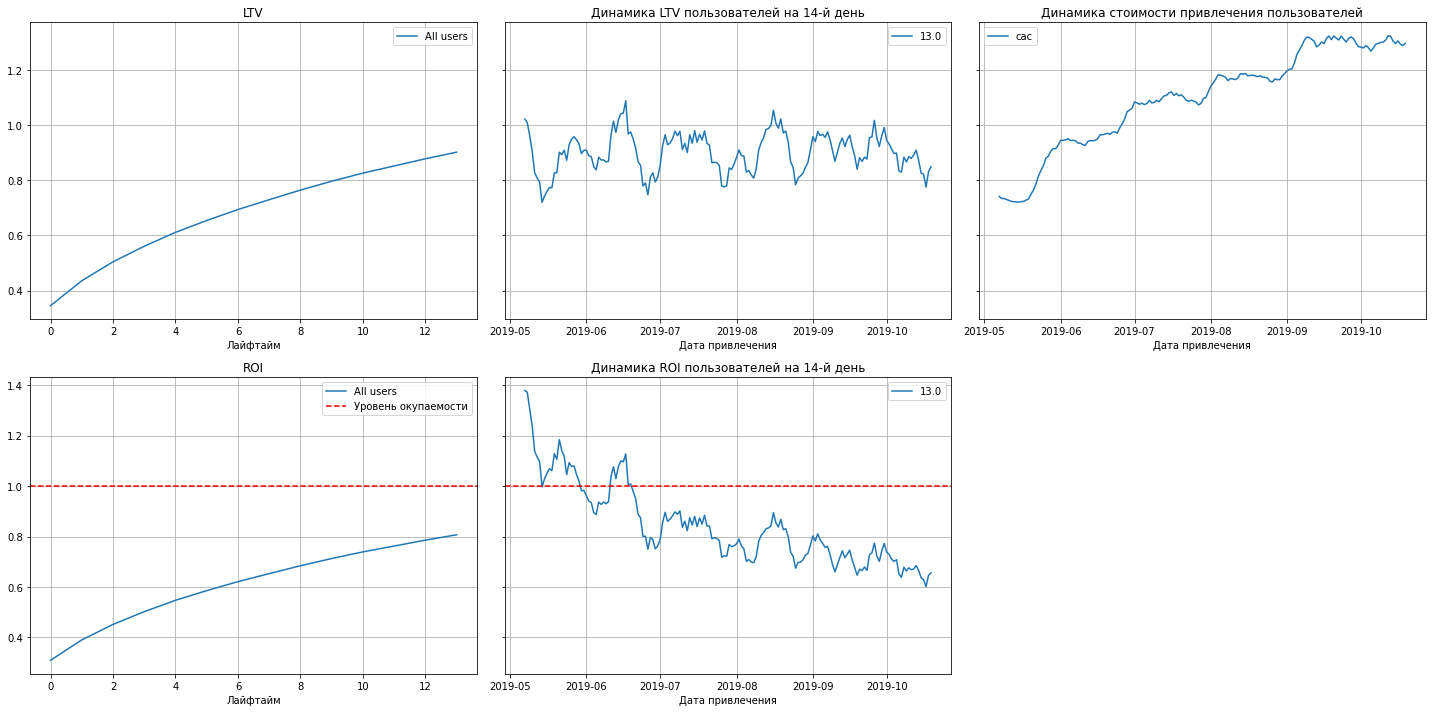

In [44]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    paid_profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:
- Реклама не окупается. ROI в конце периода —  чуть больше 80%.
- CAC нестабилен. Рекламный бюджет постоянно увеличивается, но реклама не окупается.
- На LTV влияет сезонный фактор, но этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.
- Динамика ROI уменьшается, и после середины июня уже не выходит в плюс.

### 5.2 Конверсия пользователей и динамика её изменения

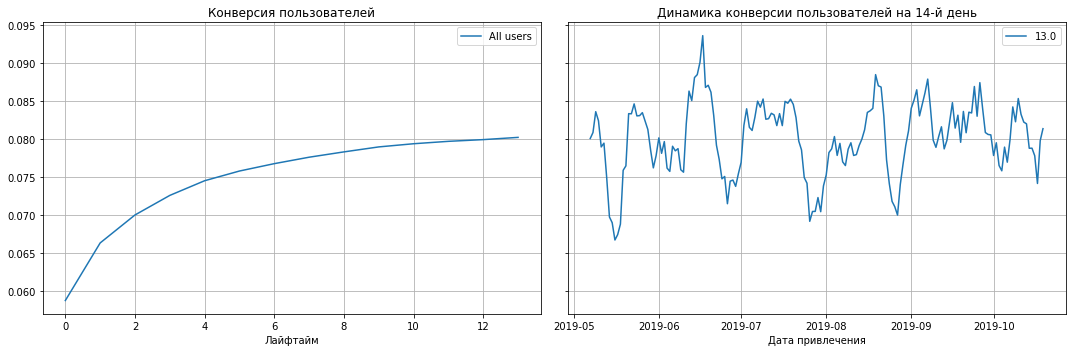

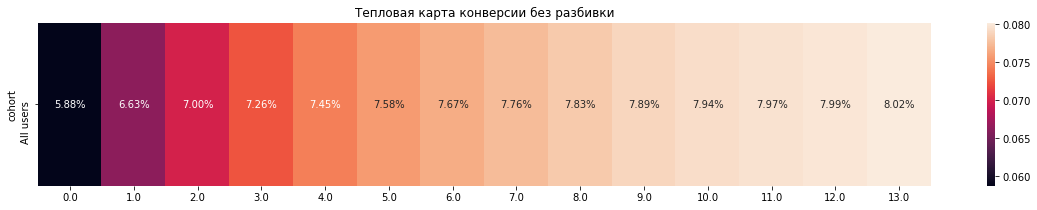

In [45]:
conversion_raw, conversion_grouped, conversion_history = get_conversion( #вызываем функцию для расчета
    paid_profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) #функция для графиков
# строим хитмэп по таблице конверсии
plt.figure(figsize=(20,3))
sns.heatmap(conversion_grouped.drop(columns=['cohort_size']), annot=True, fmt='.2%') #тепловая карта
plt.title('Тепловая карта конверсии без разбивки')
plt.show()

Конверсия к концу 14 лайфтайма составляет всего 8,02%. Динамика конверсии стабильна, хоть и имеет некоторые колебания. Конверсия растет медленно, особенно с августа.

Посмотрим конверсию в разбивкой по странам.

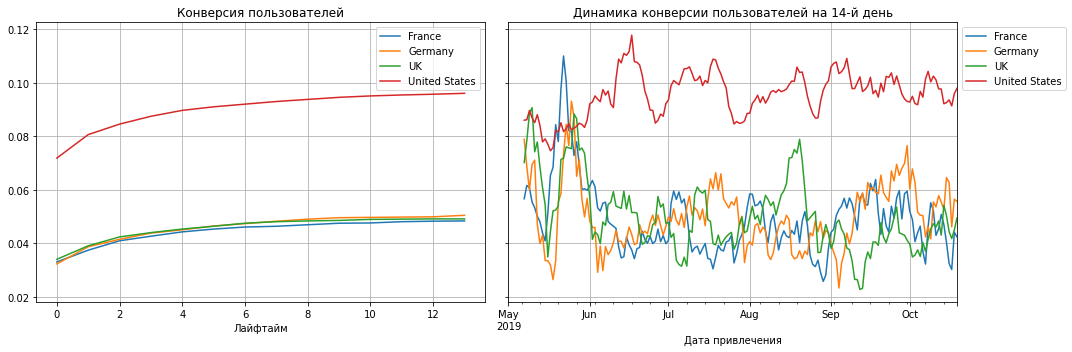

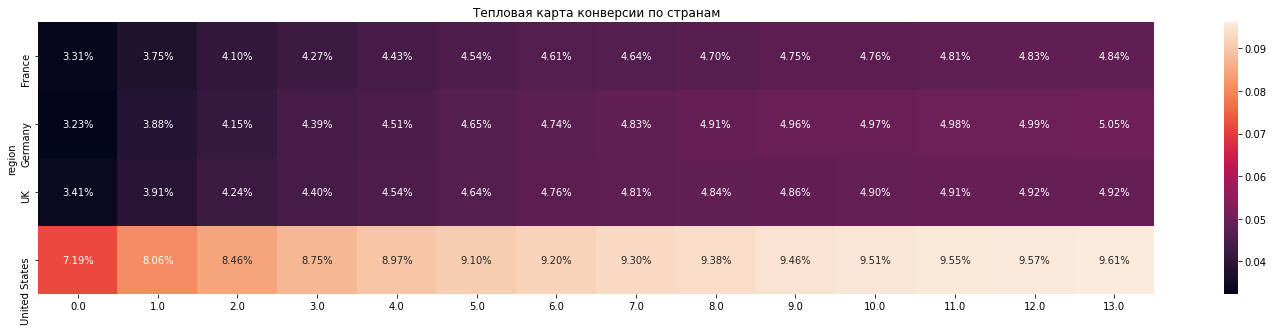

In [46]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(  #вызываем функцию для расчета конверсии
    paid_profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 
plt.figure(figsize=(25, 5)) # задаём размер сетки для графиков
sns.heatmap(conversion_grouped.drop(columns=['cohort_size']), annot=True, fmt='.2%') #тепловая карта
plt.title('Тепловая карта конверсии по странам')
plt.show()

Стабильно лучше конвертируются пользователи из USA, у остальных стран есть динамика конверсии, но она крайне мала и к концу лайфтайма все медленнее. Возможно, проблема в иностранных клиентах - например, проблемы с переводом приложения или проблемами в оплате по иностранным картам или банкам.

Посмотрим конверсию с разбивкой по устройствам.

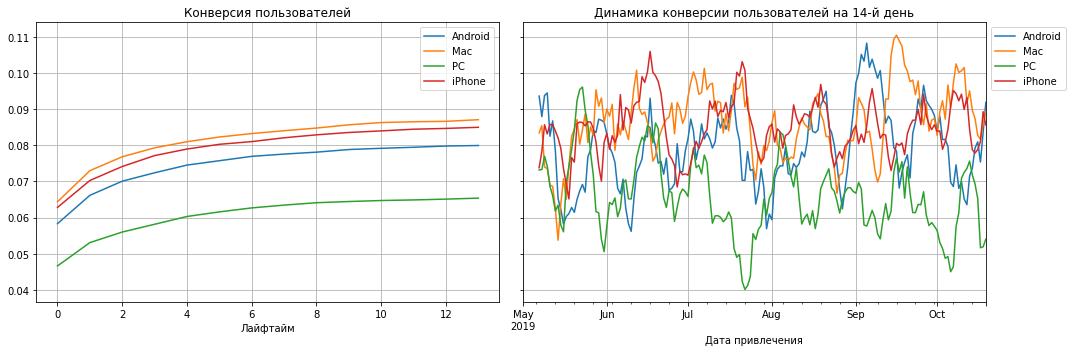

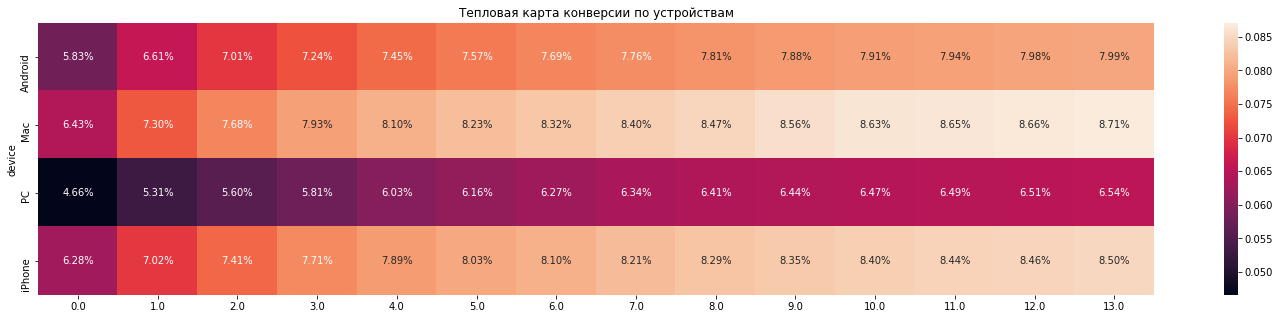

In [47]:
conversion_raw, conversion_grouped, conversion_history = get_conversion( #функция для расчета
    paid_profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)  #функция для графиков
plt.figure(figsize=(25, 5)) # задаём размер сетки для графиков
sns.heatmap(conversion_grouped.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии по устройствам')
plt.show()

По графикам заметно отстают в конверсии пользователи PC: конверсия в 1-ый лайфтайм была 4,66%, а к концу периода составляет 6,54% (разница 1,88%). В то время как у других конверсия выросла на ~2,22%.

Возможно, проблема в неудачной разработке приложения для ПК, все таки Procrastinate Pro+ - это мобильное приложение.

Посмотрим конверсию в разбивке по каналам привлечения.

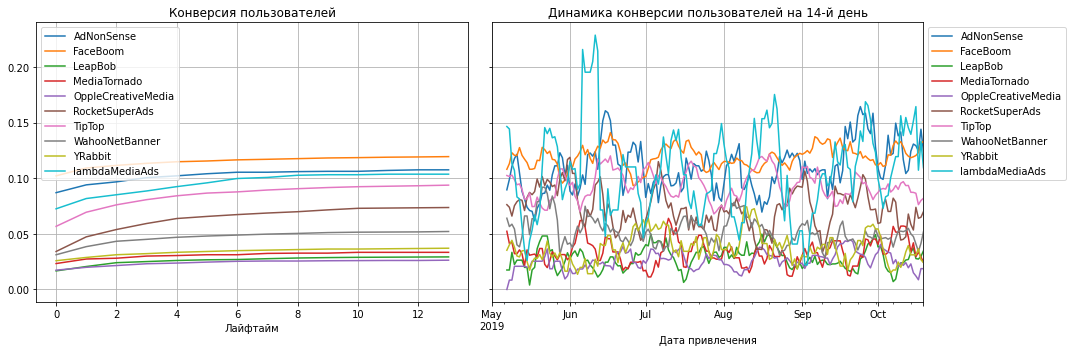

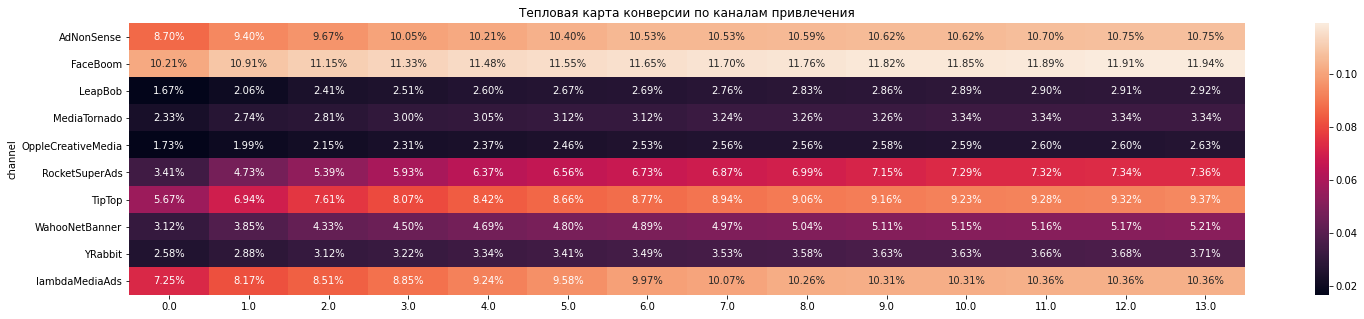

In [48]:
conversion_raw, conversion_grouped, conversion_history = get_conversion( #функция для расчетов
    paid_profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 
plt.figure(figsize=(25, 5)) # задаём размер сетки для графиков
sns.heatmap(conversion_grouped.drop(columns=['cohort_size']), annot=True, fmt='.2%') #тепловая карта
plt.title('Тепловая карта конверсии по каналам привлечения')
plt.show()

Лучше всего конвертируются пользователи из "FaceBoom", AdNonSense, lambdaMediaAds. Хуже всего LeapBob, OppleCreativeMedia, MediaTomado.

Теперь посмотрим на удержание

### 5.3 Удержание пользователей и динамика его изменения

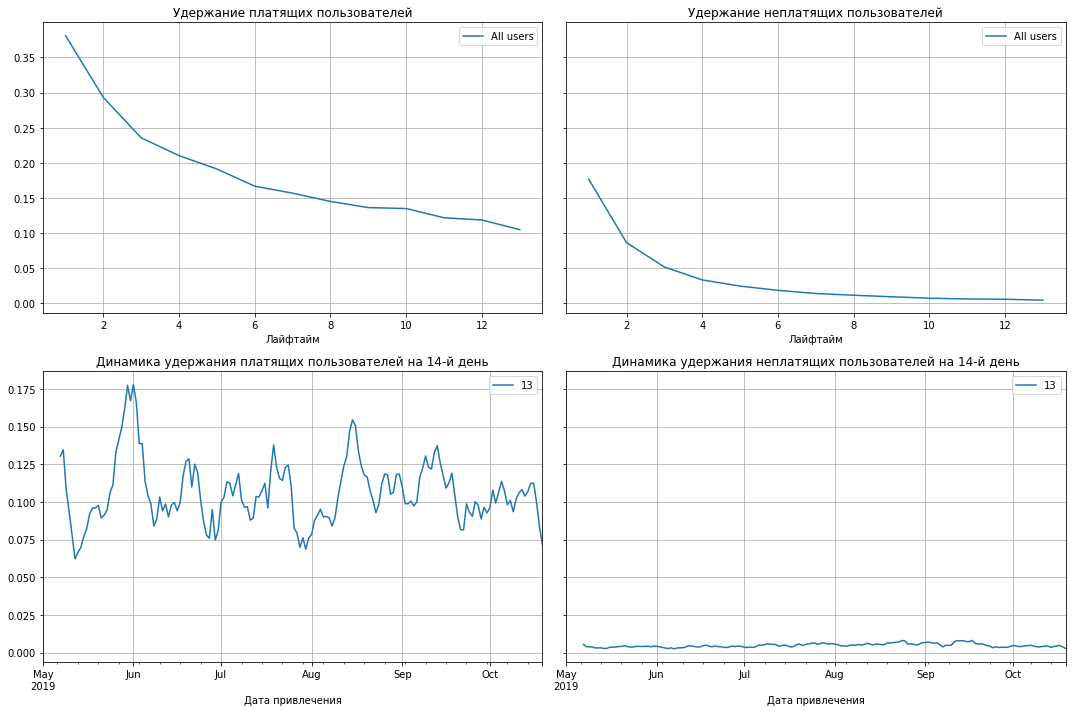

In [49]:
retention_raw, retention_grouped, retention_history = get_retention( #функция для расчета удержания
    paid_profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days)  #функция для графиков

Удержание платящих пользователей на 14 день примерно равно 0,1 и очень быстро падает. Удержание неплатящих вообще около нуля.

Динамика удержания платящих пользователей так же невысока, хоть и стабильна. 

Посмотрим то же самое, но с разбивкой по стране.

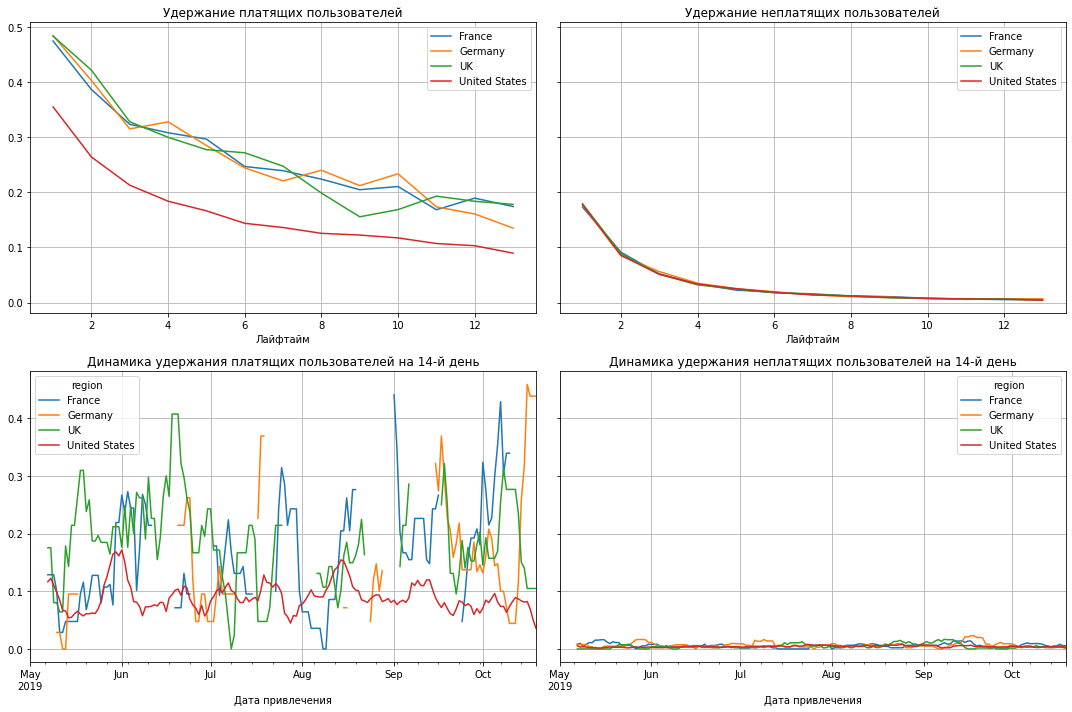

In [50]:
retention_raw, retention_grouped, retention_history = get_retention( #функция для расчета удержания
    paid_profiles, visits, observation_date, horizon_days, dimensions=['region'] #по странам
)

plot_retention(retention_grouped, retention_history, horizon_days) #графики

Удержание платящих пользователей из USA заметно ниже, чем из других стран. Пользователи из Америки хорошо конвертируются, но не задерживаются надолго. 

Посмотрим с разбивкой по устройствам.

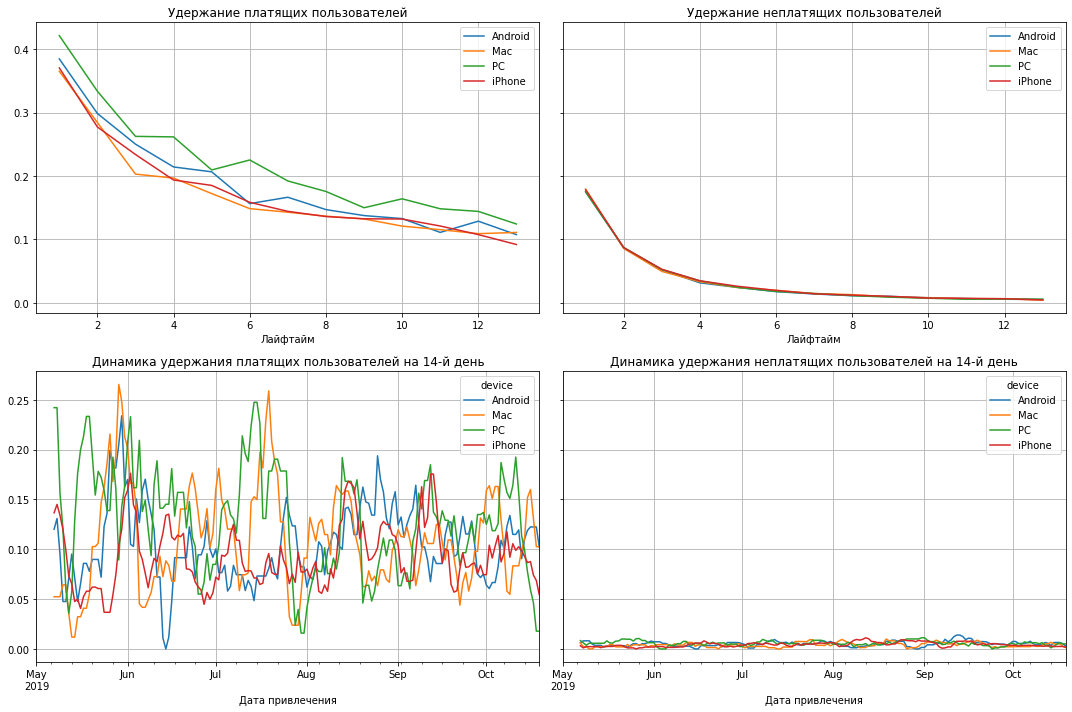

In [51]:
retention_raw, retention_grouped, retention_history = get_retention(  #функция для удержания
    paid_profiles, visits, observation_date, horizon_days, dimensions=['device'] #по устройствам
)

plot_retention(retention_grouped, retention_history, horizon_days) #графики

В разбивке по устройствам все стабильно.

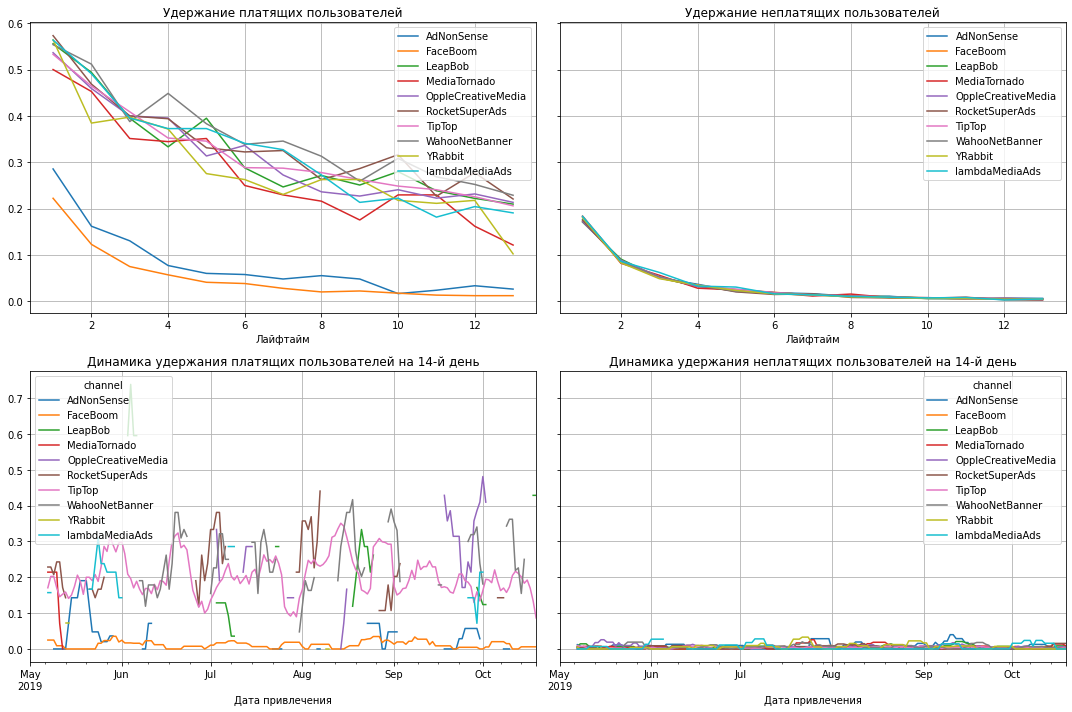

In [52]:
retention_raw, retention_grouped, retention_history = get_retention( #удержание
    paid_profiles, visits, observation_date, horizon_days, dimensions=['channel'] #по каналам
)

plot_retention(retention_grouped, retention_history, horizon_days) #графики

Очень интересная ситуация с удержанием пользователей по каналам привлечения. Лидеры по конверсии FaceBoom и AdNonSense - крайне плохо удерживаются. На 14 день у FaceBoom почти не остается платящих пользователей. Возможно, дело в аудитории на этих каналах, либо в содержании рекламы конкретно на этих каналах привлечения.

### Окупаемость рекламы с разбивкой по устройствам, странам и каналам. 

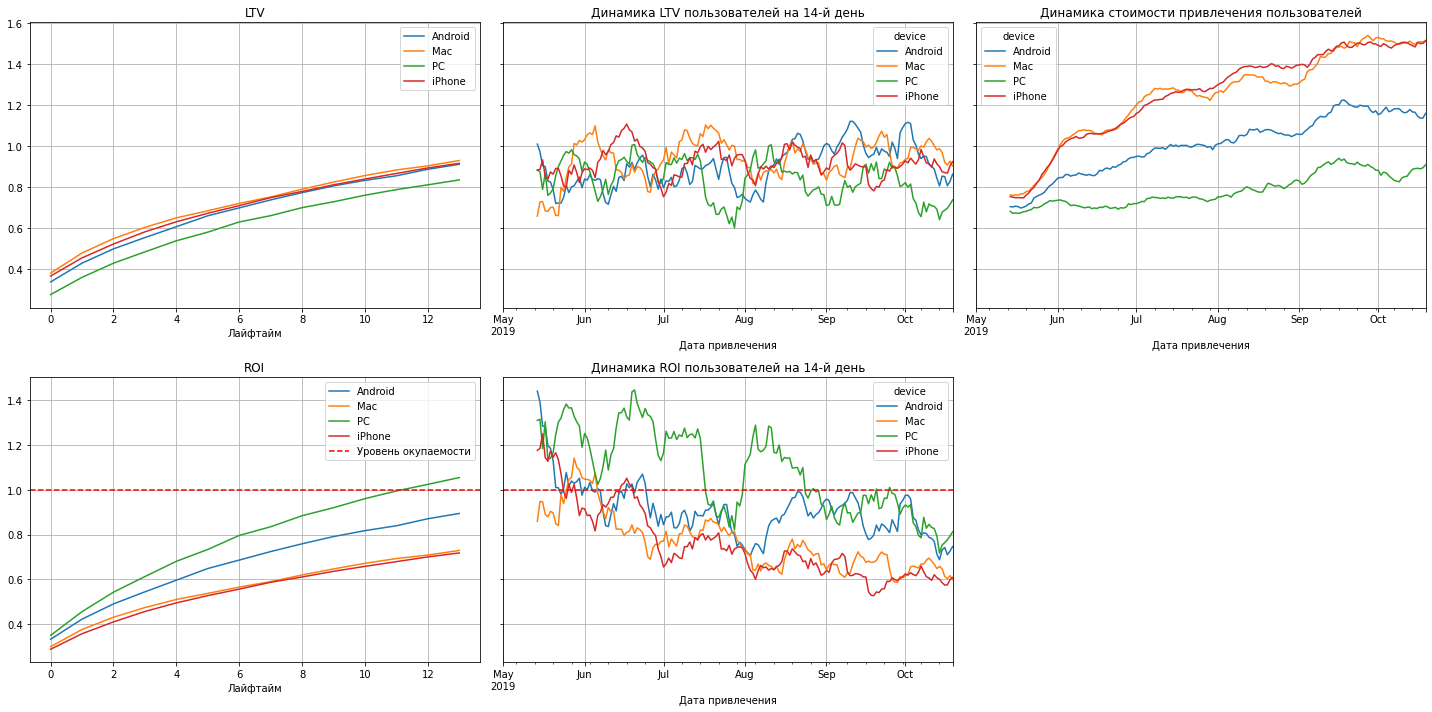

In [53]:
dimensions = ['device']  #разбивка по устройствам

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv( #LTV, ROI, CAC
    paid_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14 #графики
) 

В разбивке по устройствам окупились только пользователи PC, хотя конвертировались хуже всех. По графику динамики стоимости привлечения пользователи PC - самые дешевые.

Посмотрим разбивку по странам.

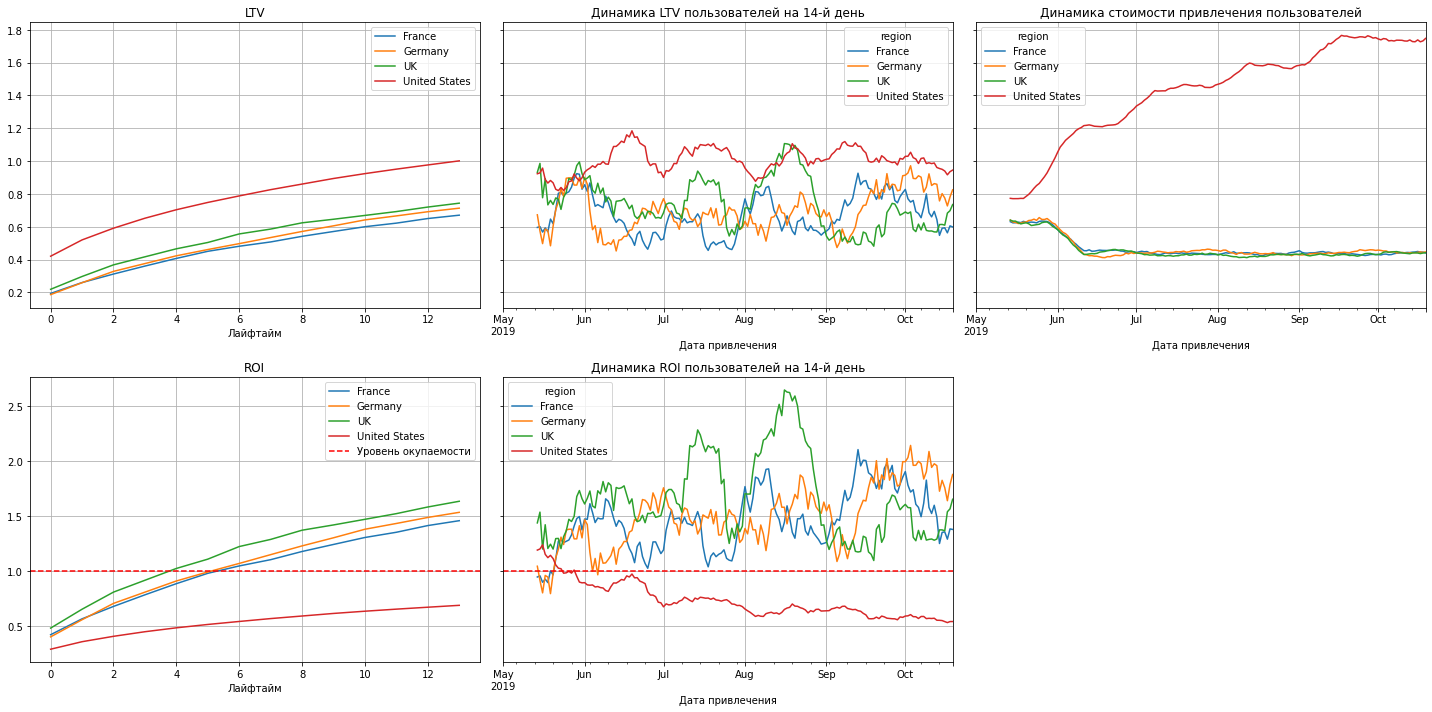

In [54]:
dimensions = ['region'] #разбивка по странам

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv( #функция для расчета
    paid_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14 #графики
) 

Интересная ситуация по разбивке по странам. Пользователи из USA дороже всего обходятся компании - CAC растет и очень быстро. Однако пользователи USA не окупаются на 14 день, в отличии от пользователей из Европы (окупились уже в 4-5 день). Возможно, компании стоит обращать внимание на пользователей из Европы больше.

Разбивка по каналам привлечения:

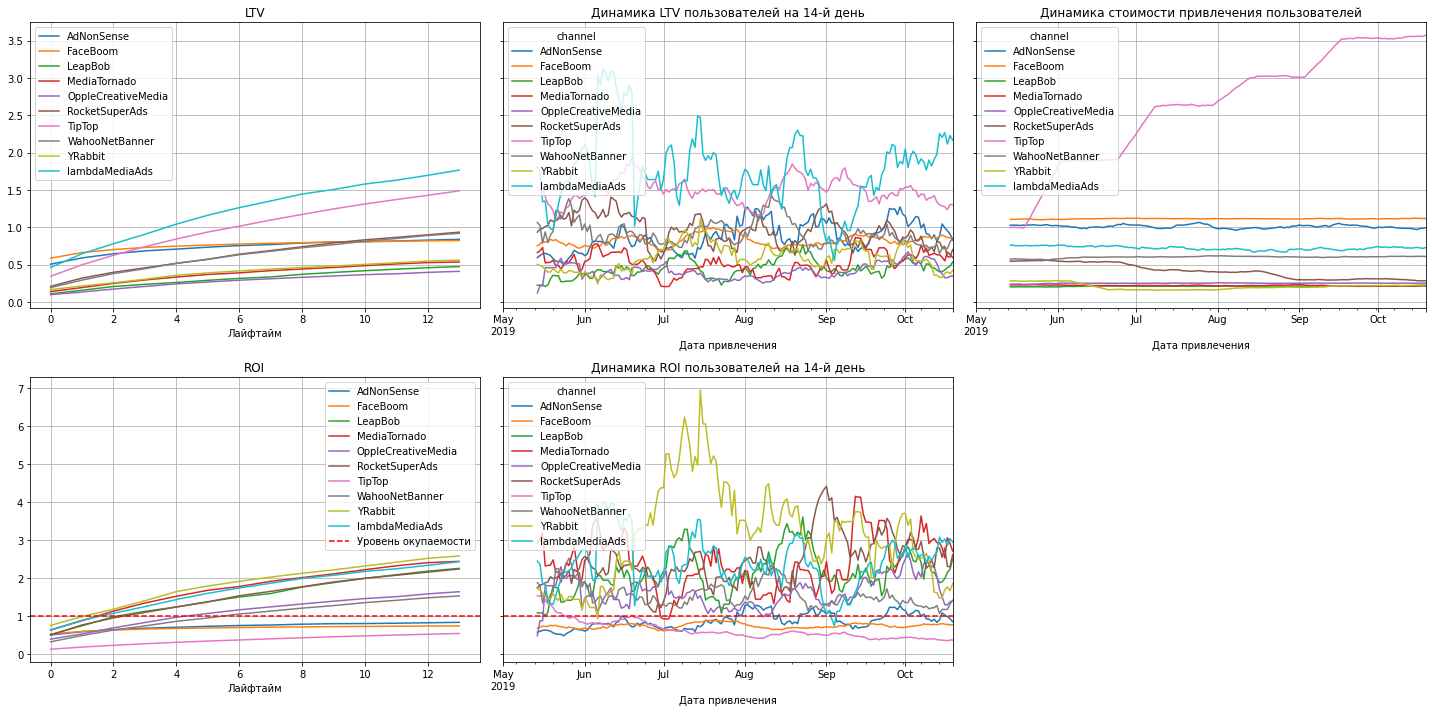

In [55]:
dimensions = ['channel'] #разбивка по каналам

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv( #функция для расчета
    paid_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14 #графики
) 

Самые "дорогие" пользователи для компании в канале "TipTop". Остальные каналы стабильны - бюджет на них не повышается. Больше всего выручки приносят пользователи из lambdaMediaAds и TipTop. Однако пользователи из "TipTop" не окупаются, так же как и пользователи "FaceBoom", "AdNonSense". 

Интересная ситуация - лидеры по конверсии не окупаются и не задерживаются в приложении.

### 5.4 Ответы на вопросы

- Окупается ли реклама, направленная на привлечение пользователей в целом?

Реклама не окупается. ROI чуть больше 80% на 14 лайфтайм. 

- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?

Хуже всего окупаются пользователи на iPhone и Mac, пользователи из USA (они самые дорогие для компании, и не окупаются, в отличии от Европы), а также каналы привлечения "TipTop", "FaceBoom", "AdNonSense". 

- Чем могут быть вызваны проблемы окупаемости?

По каналам привлечения возможны следующие проблемы: самые популярные используемые каналы компаний уже изжили свое, пользователи от них замылили глаз рекламой приложения, а компания, руководствуясь начальным успехом от этих каналом, продолжает увеличивать бюджет на рекламу в них.
Больше половины бюджета было потрачено на TipTop, а также 1/3 на FaceBoom, которые не окупаются, и в них самые дорогие клиенты. 

Возможно, стоит поработать с версией приложения для ПК (только пользователи ПК окупились, а также на них меньше всего было трат), обратить внимание на другие каналы рекламы, а также внимательно изучить проблемы, возникающие у пользователей из Европы. 
Стоит подробнее изучить, почему пользователи из США быстро покидают приложение, ведь они лучше всех конвертируются. 

# Общий вывод

В ходе исследования причин неполучения прибыли развлекательного приложения Procrastinate Pro+ были изучены три датафрейма с данными с 01.05.2019 по 27.10.2019:

- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Необходимо было предположить, почему компания терпит убытки, что мешает привлечению клиентов, и предложить пути решения проблем.

В ходе предобработки данных были составлены профили пользователей с данными о них, а также с данными о покупках и визитах в приложение.

Больше всего пользователей приложения из `United States` - 100 002 пользователя, из них платящих 6 902. Пользователей из `Европы` в сравнении в `USA` немного. Доля платящих пользователей также больше у `USA` - 6,9%.

Самым популярным устройством для входа в приложение является `iPhone` (54 479 пользователей), на втором месте `Android` (35 032). Точно также распределено количество платящих пользователей, а вот доля платящих клиентов больше у владельцев `Mac` (6,36%). 

56 439 пользователей пришли в приложение органически, доля платящих из них всего 2%. На 1 месте среди каналов привлечения `FaceBoom` (12,2%), на 2 и 3 - `AdNonSense`(11.34%) и `lambdaMediaAds`(10.47%).

Компания активно привлекает рекламных пользователей - бюджет на рекламу за исследуемый период составил 105 497,3 у.е. С течением времени бюджет увеличивается. Средняя САС = 0,687 у.е. Самый "дорогой" пользователь получился у `TipTop` (2.79), самый "дешевый" у `LeapBob` (0,21). Самыми популярными источниками рекламы у компании является `TipTop` и `FaceBoom`.

**Моментом анализа** был выбран 01.11.2019. **Горизонт анализа** - 14 дней. При расчете окупаемости рекламы не учитывались органические пользователи. 

Рекламные кампании компании не окупаются, **ROI** чуть больше 80% к 14-ому лайфтайму. **САС** нестабилен, бюджет на 1 пользователя постоянно увеличивается. Общая конверсия составляет 8,02% и растет очень медленно. Лучше всего конвертируются пользователи из `USA`, владельцы `Mac`, и пришедшие из каналов `FaceBoom`, `AdNonSense`, `lambdaMediaAds`.

Хуже всего удерживаются пользователи из `USA` и пришедшие из `FaceBoom` и `AdNonSense`. Пользователи из Америки хорошо конвертируются, но не задерживаются надолго. Возможно, дело в аудитории на этих каналах, либо в содержании рекламы конкретно на этих каналах привлечения.

В разбивке по устройствам окупились только пользователи `PC` - на них меньше всего было потрачено рекламного бюджета, хуже всего окупились владельцы устройств на iOS, к тому же, их **САС** самый высокий. 

Такая же ситуация с пользователями из Америки - на них было больше всего потрачено бюджета, и несмотря на то, что их **LTV**  превышает **LTV** Европы - пользователи из USA не окупаются совсем. В то время как европейцы окупаются на 4-5 день. 

Самые дорогие для компании клиенты пришли через `TipTop`, и бюджет на этот канал постоянно увеличивается. Однако пользователи оттуда не окупились, так же как и пользователи лидеров по конверсии FaceBoom и AdNonSense.

Судя по всему, компания достаточно долгое время вкладывалась в рекламные источники, которые уже изжили себя, но стоили очень дорого - скорее всего, команда приложения руководствовалась начальным успехом этих источников и продолжала вкладывать деньги в них. Стоит обратить внимание на такие источники, как `lambdaMediaAds`, `MediaTomado`, `YRabbit` - у них невысокая стоимость **CAC**, и высокая окупаемость **ROI** пользователей оттуда.

Исходя из всего перечисленного, можно сделать вывод, что у приложения имеются проблемы с версией приложения для `PC`, что является точкой роста. Также нужно подробнее изучить пользователей на iOS, возможны проблемы с оплатой. Кроме того, необходимо обратить внимание на клиентов из Европы - их немного, но они окупаются - это точка роста приложения. Возможны проблемы с оплатой иностранной картой или через иностранный банк. Также дополнительно стоит изучить перевод приложения на иностранные языки. 

